# CHANGEPOINT DETECTION: REALISTIC DATA AND RUNTIME ASPECTS

Welcome to Part 2 of our series about *changepoint detection*, sometimes also called *changepoint analysis*. In this series we want to explain how a changepoint is defined and also how it can be detected using standard packages.

A brief introduction to changepoint analysis can be found in our previous blog (https://github.com/cschroth2/Changepoint-Analysis/blob/master/CP-detection1-intro.ipynb ).

In this blog, we want to focus on realistic datasets. We also want to show that different algorithms can have different runtimes and how this may have an impact on the choice of your search method.

Let's import some libraries.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from pytictoc import TicToc
import pandas as pd
from pathlib import Path
import zipfile
import urllib

## 1) The UCI hydraulic dataset

In this blog we will focus on *change in mean* again. An intersting **realistic** dataset is the UCI hydraulic dataset which contains real measurements of a hydraulic test rig based on multi sensor data. A full description of the experiment can be found in (Helwig et al. 2015).

For a start, we provide some code so you can easily *download* the data from the UCI repository (https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems ) and the data will be unzipped automatically. For simplicity, the data will be saved in the local working directory.

*The required space is about  530 megabytes!*

In [7]:
# download of the data
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip',
                           "data.zip")
# unzip the data
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall()
print("download and unzip of data succesful")

download and unzip of data succesful


The dataset contains different measurement data like pressure, temperature and so on. Alltogether, there are 2205 measurements with different conditions.

The pressure measurements were taken at a frequency of 100Hz for 60 seconds, i.e. each measurement should consist of 6000 datapoints. 

Let's read an example of the data, namely the first measurement in the first pressure data file. 

In [8]:
filename = 'PS1.txt'
df = pd.read_csv( filename, header=None, delimiter='\t')
signal=df.iloc[0] # you may try other signals by changing the index 0
signal = signal.values # ruptures-package can handle numpy datasets only 
print(signal.shape)# should be (6000,) for P1.txt

(6000,)


Let's plot the signal:

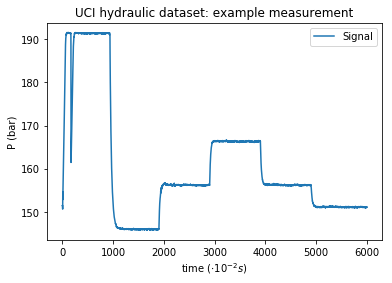

In [9]:
_, ax1 = plt.subplots()
ax1.set_title('UCI hydraulic dataset: example measurement')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.legend();

Clearly, we can identify some constant segments (constant with some noise, to be more precise). Alltogether, we have **seven phases** (one start phase at the beginning and six stationary segments).

In other words, we need to detect ***six changepoints***. We have a perfect dataset to try out changepoint algorithms! 

## 2) Brief explanation of changepoint detection in general

The *ruptures package* contains different search algorithms. In this section, we want to explain this package in more details. In fact, many changepoint detection algorithms can be understood according with help of the ideas that are implemented in the ruptures package.

Usually, the choice of the search method depends on your application and also on the domain expertise of your data.

### Main features

The ruptures package consists of three *main features*. Let's take a look at them:

- **1) search method**: 

  Recall from our previous blog (https://github.com/cschroth2/Changepoint-Analysis/blob/master/CP-detection1-intro.ipynb ) that the signal can be investigated with cost functions. The search method defines *how* the cost functions are applied, e.g. for the whole signal or only for a part of the signal. We have 5 different methods, namely

  - Binary segmentation
  - Exact segmentation: dynamic programming
  - Exact segmentation: Pelt
  - Bottom-up segmentation
  - Window-based change point detection.
 
 We will see more details (advantages and drawbacks) about the different search methods later.


- **2) cost function**: 

  There are 3-8 cost functions available, depending on the search method you chose . However, in many applications it is sufficient to take the *least squared deviation* (denoted by "l2"), and we recommend to start with "l2". 
 
 
- **3) constraint**: 

  The constraint parameter defines how the changepoint candidates are selected, knowing the costs for each datapoint. 
  
  There are three constraints available, namely
  - n_bkps (number of breakpoints): choose this constraint if you know how many changepoints you have in your signal.
  - pen (penalty): try the penalty constraint if you do not know how many changepoints you will have.
  - epsilon: try epsilon alternatively if you do not know how many changepoints you will have.
  
 Note that a constraint must (and only one can) be provided when you apply the ruptures package.

### Optional features

The ruptures package offers *optional features* to tune the methods. The optional features can somehow be interpreted as hyperparameter to tune a model. Let's briefly consider the most relevant of those. Note, that not all of these features are available for every search method.

 - min_size (minimum segment length): makes sure that there is enough distance between two changepoints.
 - jump: can be used to speed up the evaluation (but results may become a little bit  inaccurate)
 - width: is the window length and only available for the Window-based method.
 
**Remark**: it depends on your data (and your knowledge about your data) which features and which values you choose.

## 3) Different methods and their runtime

In general, the longer the runtime of an algorithm the more acurrate are the detected changepoints. But the runtime matters if you need an online application, for example. Therefore, we consider, how long an algorithm takes. 


To compare the runtime of the following algorithms, let's track the time each method needs:

In [6]:
t = TicToc()

### Exact segmentation: dynamic programming

The main idea of most changepoint detection methods is to find a segmentation, such that the costs for the segments gets minimized. In the *dynamic programming method* all possible subsegments are calculated. This algorithms yields the most accurate changepoints in the ruptures package.

In the following, let $T$ denote the signal length, in the example above we have $T=6000$.

As the *dynamic programing method* calculates all subsegments but the runtime is $\mathcal{O}(T^2)$. Let's run the model and consider the results and the runtime.

*The following calculation may take some seconds!*

In [7]:
t.tic()
# define the search method: binary segmentation; select cost function "l2"
algo = rpt.Dynp(model="l2").fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[45, 955, 1915, 2915, 3915, 4915, 6000]
Elapsed time is 49.034233 seconds.


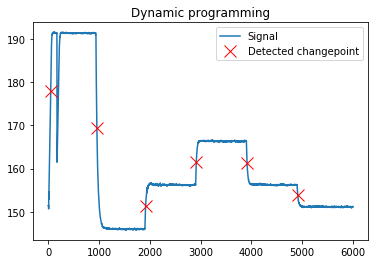

In [8]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Dynamic programming')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

More than 40 seconds are deinitely too much for an online real time application. Let's tune the method by adding the optional parameter jump. This will yield a much faster runtime:

In [9]:
t.tic()
# define the search method: binary segmentation; select cost function "l2"
# add optional parameter here
algo = rpt.Dynp(model="l2", jump=20).fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[40, 960, 1920, 2920, 3920, 4920, 6000]
Elapsed time is 2.911825 seconds.


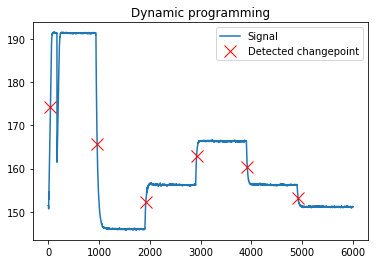

In [10]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Dynamic programming')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Indeed, the tuning speeds up the runtime and yields (almost) the same result.

### The Binary segmentation method

The *binary segmentation method* is a well established method in changepoint analysis. This method starts by dividing the signal in two segments and takes the two segments which have the minimal cost. So, we get the first changepoint that is now fixed. After that it subdivides one of the two remaining segments with the second changepoint, obtaining three segments and so on. 

One benefit is a short runtime, since the runtime is $\mathcal{O}\big(T\cdot log(T)\big)$. However, in general it yields only an approximation of the optimal changepoints (Truong et al. 2018).

Let's calculate and plot the changepoints that are detected by the binary segmentation.

In [11]:
t.tic()
# define the search method: binary segmentation; select cost function "l2"
algo = rpt.Binseg(model="l2").fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[45, 950, 1920, 2915, 3945, 4915, 6000]
Elapsed time is 0.426497 seconds.


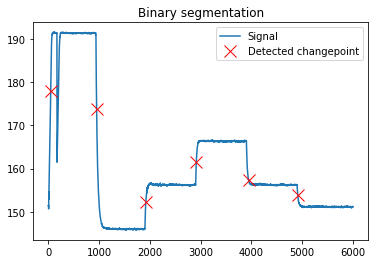

In [12]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Binary segmentation')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

If we compare the *binary segmentation method* and the *dynamic programming method* we can see that they calculate (almost) the same changepoints.

But if we compare the runtime, the dynamic programming takes more than 40 seconds whereas the binary segmentation takes 0.4 seconds only. Relatively spoken, the runtime of the dynamic is of order $10^2$ times the runtime of the binary segmentation. This id the difference between the quadratic runtime of the *dynamic programming method* and the shorter runtime of the *binary segmentation method*. This effect increases as the signal length gets larger and larger. 

### Pelt

The *Pelt method* (Pelt=Pruned exact linear time) has - theoretically - the shortest runtime of all search methods in the ruptures package. It somehow keeps only the relevant changepoint candidates and drops other changepoint candidates recursively. 

The **expected** runtime is $\mathcal{O}(T)$, however the **worst case** runtime can be $\mathcal{O}(T^2)$. In practical application, it is often the case that this method is actually slower than the *binary segmentation method*.

It is important to mention that the *Pelt method* cannot be applied with the constraint n_bkps, the provided constraint must be the *penalty*.

Let's try it out:

In [13]:
t.tic()
# define the search method: binary segmentation; select cost function "l2"
# add optional parameter: min_size
algo = rpt.Pelt(model="l2").fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(pen=1)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 235, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1025, 1035, 1045, 1060, 1085, 1205, 1905, 1910, 1915, 1920, 1925, 1935, 1945, 1960, 1980, 2080, 2905, 2910, 2915, 2920, 2925, 2930, 2940, 2955, 3905, 3910, 3915, 3920, 3925, 3930, 3940, 3955, 3985, 4290, 4905, 4910, 4915, 4920, 4930, 4945, 4985, 6000]
Elapsed time is 4.215984 seconds.


Obviously, we have two issues:

- the runtime is longer as the runtime of the *binary segmentation*, even if Pelt is (theoretically) an algorithm with shorter runtime
- the method found too much changepoints. 

Let's plot the result:

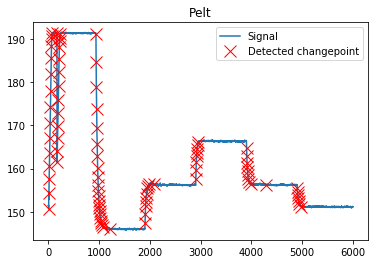

In [14]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Pelt')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Well, most of them are around the changepoints but it is not what we would expect. To fix this, let's raise the penalty value and add a *min_size*:

In [15]:
t.tic()
# define the search method: binary segmentation; select cost function "l2"
# add optional parameter here
algo = rpt.Pelt(model="l2", min_size=600).fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(pen=10)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[960, 1915, 2915, 3915, 4915, 6000]
Elapsed time is 0.085079 seconds.


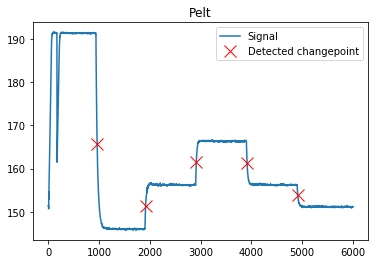

In [16]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Pelt')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

That looks much better. But only after we *adjusted* the method and its parameters. In general, the right choice of the parameters is not straightforward.

Note, that we did not provide the number of changepoints when we called the algorithm, i.e. this time the method did not search the "5 best points" but the points where the penalty value was large enough.

### Bottom-up segmentation

The bottom-up approach is somehow the "counterpart" (Truong et al. 2018) to the binary segmentation method and has also a runtime of $\mathcal{O}(T\cdot log(T))$. 

Both methods should yield similar results. Let' check this:

In [17]:
t.tic()
# define the search method: binary segmentation; select cost function "l2"
algo = rpt.BottomUp(model="l2").fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[55, 955, 1915, 2910, 3915, 4915, 6000]
Elapsed time is 0.995384 seconds.


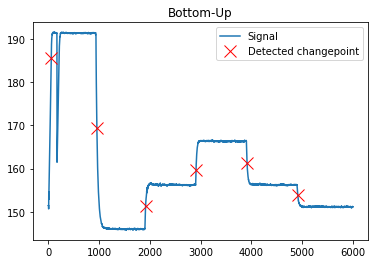

In [18]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Bottom-Up')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Indeed, the *bottom-up* approach yields (almost) the same changepoints as the *binary segmentation method*.

### Window-based 

The idea of the window based approach can be used for an online application. This method should yield the shortest runtime without tuning. The runtime is $\mathcal{O}(T)$, the following animation will illustrate the idea of the *window-based method*:

In [19]:
%%HTML

<div align="middle">
<video width="50%" controls>
      <source src="./Images/demo-window-based-ruptures.mp4" type="video/mp4">
</video></div>

Obviously, the runtime is linear with respect to the time series length. Of course, the window length also influences the runtime, still the runtime stays linear.

Let's see if it works and also if the *window-based methoid* is really faster than the *binary segmentation method*.

In [20]:
t.tic()
# define the search method: binary segmentation; select a different cost function here
algo = rpt.Window(width=100,model="l2",min_size=200).fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)
t.toc()

Detected changepoints:
[50, 955, 1915, 2915, 3915, 4915, 6000]
Elapsed time is 0.073283 seconds.


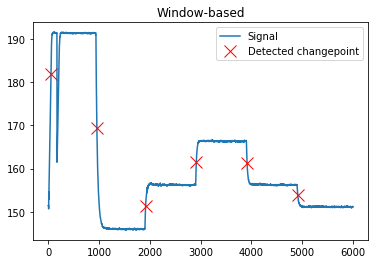

In [21]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Window-based')
ax1.plot(signal, label='Signal')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

We can see clearly that the window-based approach beats all other methods in runtime. This is not surprising because the runtime is linear and therefore shorter than the other methods we've seen.

## 4) Discussion

We have seen five methods that are able to identify changes in mean. We have a real dataset taken from an experiment of a hydraulic test rig. The right choice of the search method depends on your application and knwowledge about your data. Also, with the *Pelt method* we could identify changepoints without providing the information, how many changepoints there will be. 

Note, the we covered changes in mean only, it is still unclear if the presented methods will work for other changes.

### Summary

Let's summarize the advantages and shortcomings of the *ruptures* package:

**Advantages:**

- easy to apply
- detection of changes in mean possible
- short runtime available.

**Shortcomings:**

- unclear, if other changes can be detected
- choice of the method not always straightforward.

## 5) Literature

- Nikolai Helwig, Eliseo Pignanelli, Andreas Schütze, ‘Condition Monitoring of a Complex Hydraulic System Using Multivariate Statistics’, in Proc. I2MTC-2015 - 2015 IEEE International Instrumentation and Measurement Technology Conference, paper PPS1-39, Pisa, Italy, May 11-14, 2015, doi: 10.1109/I2MTC.2015.7151267.
- Truong, Charles; Oudre, Laurent; Vayatis, Nicolas (2018b): Selective review of offline change point detection methods.